In [1]:
import pandas as pd
import numpy as np
from plotnine import *

%matplotlib inline

In [3]:
data = pd.read_csv("../../data/processed/expensas_full_processed.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [6]:
data.shape

(162595, 24)

In [23]:
data.columns

Index(['expensa_id', 'consorcio_id', 'consorcio_nombre',
       'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
       'consorcio_prop_efectivo', 'unidad_id', 'unidad_denominacion',
       'unidad_tipo', 'unidad_prop_impagos', 'expensa_proporcion',
       'expensa_interes_primer_vencimiento',
       'expensa_ineteres_segundo_vencimiento', 'expensa_mes', 'expensa_fecha',
       'expensa_mes_pago', 'expensa_mes_pago_anterior', 'pago_metodo_lag_1',
       'pago_metodo_lag_2', 'pago_metodo_lag_3', 'pago_metodo_lag_4',
       'pago_metodo_lag_5', 'pago_metodo_lag_6', 'target'],
      dtype='object')

## Train-CV-Test Split Explanation

In [8]:
aux_df = data
aux_df = aux_df.sort_values("expensa_mes_pago").reset_index()

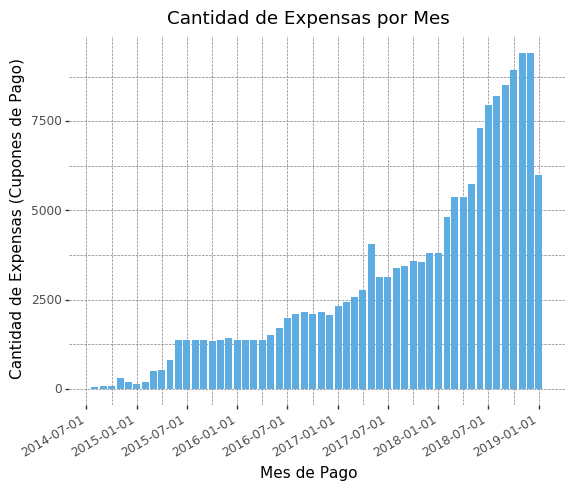

<ggplot: (-9223371889316058834)>

In [9]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago"), fill="#5DADE2")
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

In [16]:
test_size = round(len(aux_df) * 0.2)
cv_size = round(len(aux_df)*0.8*0.2)

In [17]:
from sklearn.model_selection import train_test_split
min_test_id = (aux_df.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(aux_df))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train, idx_cv = train_test_split(idx_train_cv, shuffle = True, test_size =cv_size)
idx_train += range(0, min_test_id)

In [19]:
aux_df["group"] = "0"
aux_df.loc[idx_train, "group"] = "train"
aux_df.loc[idx_cv, "group"] = "cv"
aux_df.loc[idx_test,"group"] = "test"

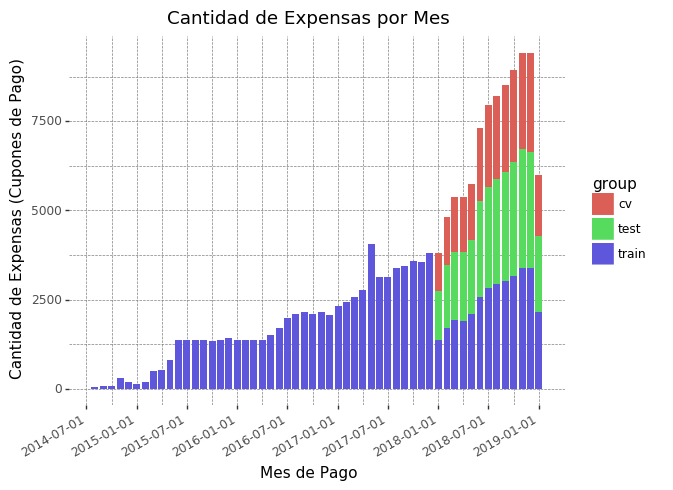

<ggplot: (-9223371889315343956)>

In [20]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago", fill="group"))
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

### Split

In [59]:
data = data.sort_values("expensa_mes_pago").reset_index().drop(columns="index")

In [60]:
X_columns  = [ 'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
               'consorcio_prop_efectivo',
               'unidad_tipo', 'unidad_prop_impagos', 
               'expensa_proporcion',
               'expensa_interes_primer_vencimiento',
               'expensa_ineteres_segundo_vencimiento', 'expensa_mes',
               'pago_metodo_lag_1', 'pago_metodo_lag_2', 'pago_metodo_lag_3', 
               'pago_metodo_lag_4', 'pago_metodo_lag_5', 'pago_metodo_lag_6']

In [61]:
min_test_id = (data.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(data))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train_cv += range(0, min_test_id)

In [62]:
idxs_train_cv2 = range(min_test_id, len(idx_train_cv))
idx_train, idx_cv = train_test_split(idxs_train_cv2, shuffle = True, test_size =cv_size)
idx_train += range(0, min_test_id)

In [63]:
X_train_cv = data.loc[idx_train_cv, X_columns + ["expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
Y_train_cv = data.loc[idx_train_cv, ["target","expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
X_test = data.loc[idx_test,X_columns]
Y_test = data.loc[idx_test, ["target"]]

## Dummies y Scaler

In [64]:
X_train_cv = pd.get_dummies(X_train_cv)
X_test = pd.get_dummies(X_test)

In [67]:
delete_columns = [column for column in X_test.columns if column not in X_train_cv.columns]
X_test = X_test.drop(columns = delete_columns)

In [69]:
print(X_train_cv.shape)
print(X_test.shape)

(130076, 56)
(32519, 56)


In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_cv[["consorcio_cantidad_expensas"]])
X_train_cv.consorcio_cantidad_expensas = scaler.transform(X_train_cv[["consorcio_cantidad_expensas"]])
X_test.consorcio_cantidad_expensas = scaler.transform(X_test[["consorcio_cantidad_expensas"]])

## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegressionCV

linear_modelCV = LogisticRegressionCV(
    cv = [(idx_train, idx_cv)],
    scoring = "f1",
    n_jobs = -1,
    verbose = 5,
    refit = True,
)

In [73]:
linear_modelCV.fit(X_train_cv, Y_train_cv)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.5s finished


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=[([120871, 102533, 97442, 76074, 115827, 118924, 97995, 115779, 71935, 99829, 85552, 110173, 86255, 93484, 121096, 106625, 99968, 126108, 87402, 74758, 126266, 93879, 106903, 98312, 98816, 122539, 120844, 102740, 100233, 111348, 89783, 111575, 72844, 115590, 100847, 74969, 79756, 115729, 129743, ..., 124873, 120177, 73100, 121060, 76125, 123902, 72542, 123412, 87262, 81355, 100341, 97504, 76880])],
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='f1', solver='lbfgs',
           tol=0.0001, verbose=5)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_preds = linear_modelCV.predict(X_train_cv)
print("accuracy:", accuracy_score(Y_train_cv, train_preds))
print("precision:", precision_score(Y_train_cv, train_preds))
print("recall:", recall_score(Y_train_cv, train_preds))
print("f1:", f1_score(Y_train_cv, train_preds))
print("--------------------------------------------------")
test_preds = linear_modelCV.predict(X_test)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

accuracy: 0.8819766905501399
precision: 0.8124476987447699
recall: 0.7002764921560377
f1: 0.7522032475707783
--------------------------------------------------
accuracy: 0.8799778590977583
precision: 0.7844118121671777
recall: 0.6544157242864835
f1: 0.7135412844036697


## Analisis de Coeficientes

In [77]:
lm_coef = pd.DataFrame({
    "variable": X_train_cv.columns,
    "coef": linear_modelCV.coef_[0]
})

In [79]:
lm_coef["abs_coef"] = abs(lm_coef.coef)

In [80]:
from pandas.api.types import CategoricalDtype
lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
lm_coef = lm_coef.reset_index().drop(columns="index")

variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
lm_coef.variable = lm_coef.variable.astype(variable_cat)

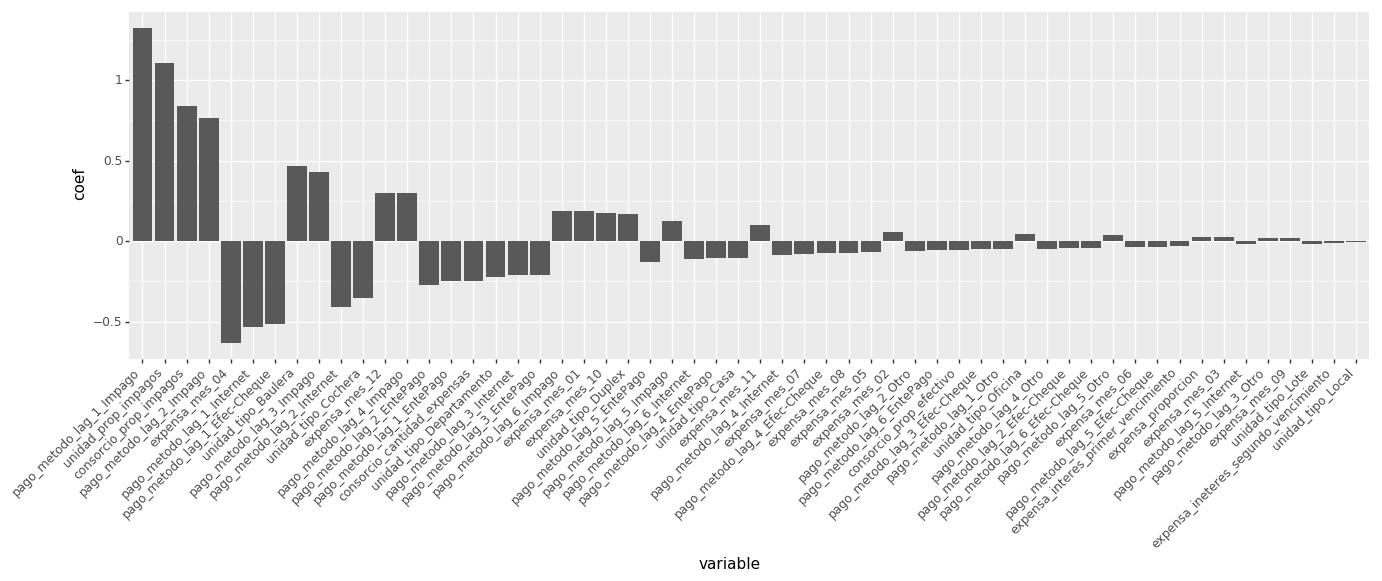

<ggplot: (147550731668)>

In [81]:
figure_size = (16, 4.8)
(ggplot(data=lm_coef)
+ geom_bar(aes(x = "variable",y="coef"), stat = "identity")
+ theme( axis_text_x = element_text(angle = 45, hjust = 1),
          figure_size = (16, 4.5))
)

### Analisis de errores

In [82]:
data_test = data.loc[idx_test,:]

In [83]:
data_test["preds"] = test_preds

In [84]:
data_test["error"] = data_test.preds != data_test.target

In [85]:
data_test.loc[data_test.error,:]

,expensa_id,consorcio_id,consorcio_nombre,consorcio_cantidad_expensas,consorcio_prop_impagos,consorcio_prop_efectivo,unidad_id,unidad_denominacion,unidad_tipo,unidad_prop_impagos,...,expensa_mes_pago_anterior,pago_metodo_lag_1,pago_metodo_lag_2,pago_metodo_lag_3,pago_metodo_lag_4,pago_metodo_lag_5,pago_metodo_lag_6,target,preds,error
106304,259384,827,Coppar,518.0,0.449807,0.438224,14608,PH 209,Cochera,0.348837,...,2018-06-01,Efec-Cheque,Efec-Cheque,Efec-Cheque,Efec-Cheque,Efec-Cheque,Efec-Cheque,1.0,0.0,True
132998,333711,1763,TORRE CALMA,69.0,0.449275,0.086957,38929,4º C,Departamento,0.285714,...,2018-09-01,Impago,EntePago,EntePago,Impago,EntePago,EntePago,1.0,0.0,True
101744,244263,534,PORTAL DEL SOL,46.0,0.239130,0.000000,8675,7B,Departamento,0.044444,...,2018-05-01,Impago,EntePago,EntePago,EntePago,EntePago,EntePago,1.0,0.0,True
129659,324843,1690,Gran Estrada III,203.0,0.177340,0.113300,36074,PH 126 - 7º Piso Dpto. B,Departamento,0.909091,...,2018-09-01,Efec-Cheque,Impago,Impago,Impago,Impago,Impago,0.0,1.0,True
105577,269077,1584,Florida XXV,49.0,0.224490,0.000000,30325,4º DPTO. D,Departamento,0.250000,...,2018-06-01,Impago,EntePago,EntePago,EntePago,Impago,EntePago,1.0,0.0,True
87823,215436,1639,PLAZA COLON,67.0,0.074627,0.820896,33173,9 G,Departamento,0.000000,...,2018-03-01,Efec-Cheque,Efec-Cheque,Efec-Cheque,Efec-Cheque,Efec-Cheque,Internet,1.0,0.0,True
111460,263335,1617,MARIA REINA X,76.0,0.118421,0.039474,31731,7º C,Departamento,0.083333,...,2018-06-01,EntePago,EntePago,EntePago,Impago,EntePago,EntePago,1.0,0.0,True
136143,325542,1711,Edificio Mejico,32.0,0.187500,0.281250,36869,5º D,Departamento,0.333333,...,2018-09-01,Efec-Cheque,Efec-Cheque,Impago,Efec-Cheque,Efec-Cheque,Efec-Cheque,1.0,0.0,True
96679,237680,1648,Altos Y Bosques de Catalina,369.0,0.457995,0.000000,34232,AC-09-17,Departamento,0.625000,...,2018-04-01,EntePago,Impago,Impago,Impago,EntePago,EntePago,1.0,0.0,True
141926,350395,1651,Edificio Barrancas,30.0,0.266667,0.100000,34558,"5 C""""",Departamento,0.538462,...,2018-10-01,Efec-Cheque,Impago,Impago,Impago,Impago,Efec-Cheque,1.0,0.0,True
